## Analysis of ZTF Light Curves

We are going to search through ZTF light curves in order to find ones that have "dips" in their brightness. This is a part of on-going work by the time-domain group in the UW DiRAC Institute to find a Boyajian-like star in the ZTF dataset. The figure below outlines this process, where we ingest all of the ZTF light curves and construct a filter (in Python) that is then applied over all of the light curves in parallel using Apache Spark. The resulting dataset contains just the dipping light curves identified by our filter.

<div style="margin-right: 50px">
    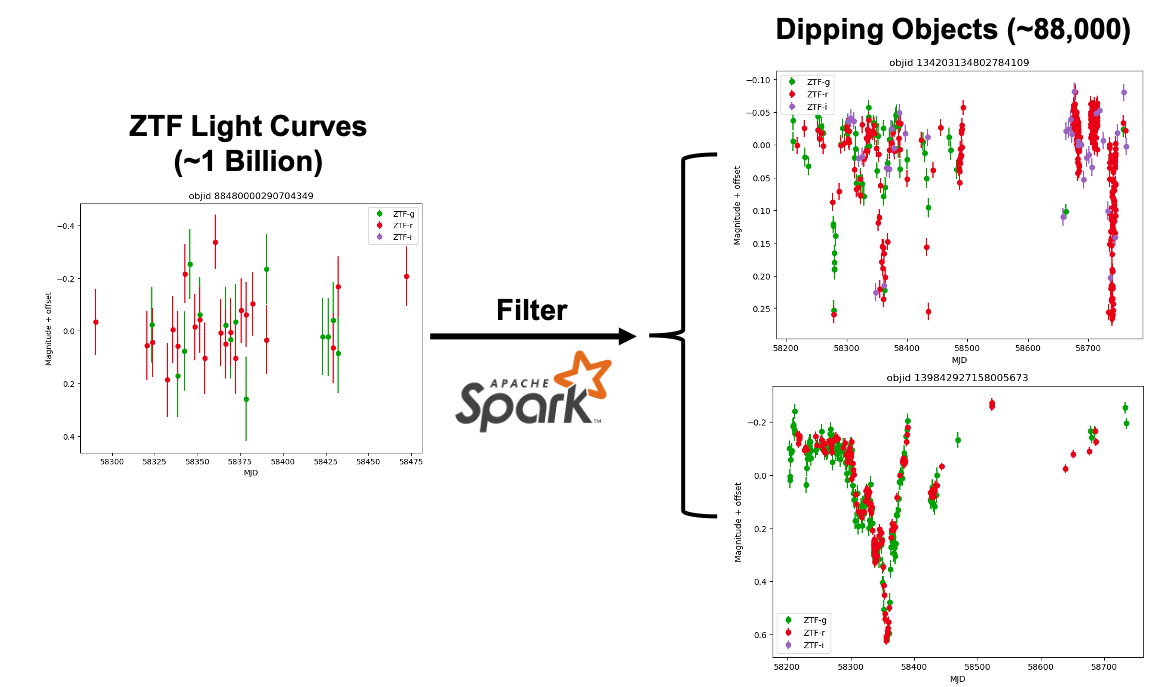
</div>

Dipper search code was written by [Kyle Boone](https://escience.washington.edu/people/kyle-boone/) in collaboration with the UW DiRAC time-domain group.

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sparkfunc
import axs
import dipper

In [ ]:
import getpass
username = getpass.getuser()

import os
SPARK_EXECUTOR_PYTHONPATH = os.getcwd() + ":" + os.environ['PYTHONPATH']

### Creating a Spark Cluster

We construct a Spark cluster on Kubernetes using the following "boilerplate" code. We tell Spark to use the Kubernetes API by setting `spark.master=k8s://https://kubernetes.default.svc:443`. We request 8 machines to distribute work over by setting `spark.executor.instance=8`. The memory of these machines is managed with `spark.executor.memory` and `spark.executor.memoryOverhead`. We provide 6500 MiB of memory to Python processs (`spark.executor.memoryOverhead=6500m`) on the executor machines, which should be plenty for the query we plan to run.

The Spark cluster will not be created immediately unless there is excess compute capacity in the Kubernetes cluster equaling the request you made, which is unlikely. You may have to wait ~5 minutes as Kubernetes makes a request to AWS for 8 more EC2 virtual machines to be allocated for us. If you delete the Spark cluster, the EC2 virtual machines will be removed within ~10 minutes. If you recreate a Spark cluster in this time frame, it is likely that your Spark cluster will be recreated quickly.

### Sharing Code and Environments

Code is shared between this notebook and the Spark executor machines through a Network File System. The Spark executor machines will share files with you in the directories `/home/{username}` and `/opt/conda/envs`. We must pass the `PYTHONPATH` environment variable (set to the current directory of this notebook) to the executor so that Spark executors can `import dipper` (as we've done above) to access and execute our Python code. Additionally, a start-up script can be executed on the executor machines by setting `spark.executorEnv.SPARK_START_SCRIPT` to the name of a file in either `/home/{username}` or `/opt/conda/envs`. For example, you can create a Bash script that will run `conda activate DipperEnvironment` when the executor machines start up so that they will work from a codebase shared with you.

In [ ]:
spark = (
    SparkSession
    .builder
    .config("spark.master", "k8s://https://kubernetes.default.svc:443")
    .config("spark.executor.instances", "8")
    .config("spark.executor.memory", "1000m")
    .config("spark.executor.memoryOverhead", "6500m")
    .config("spark.executorEnv.PYTHONPATH", SPARK_EXECUTOR_PYTHONPATH)
#   You can add a start-up script to execute arbitrary code on a Spark executor machine starts before it starts
#     .config("spark.executorEnv.SPARK_START_SCRIPT", f"/home/{username}/spark-start.sh")
    .enableHiveSupport()
    .getOrCreate()
)
sc = spark.sparkContext

### Monitoring the Spark Cluster

Spark exposes a web user interface (UI) that will show you the status of the Spark cluster and any running jobs. Run the following cell to get a URL that points to the UI. This will look something like the following image.

<div style="margin: 30px">
    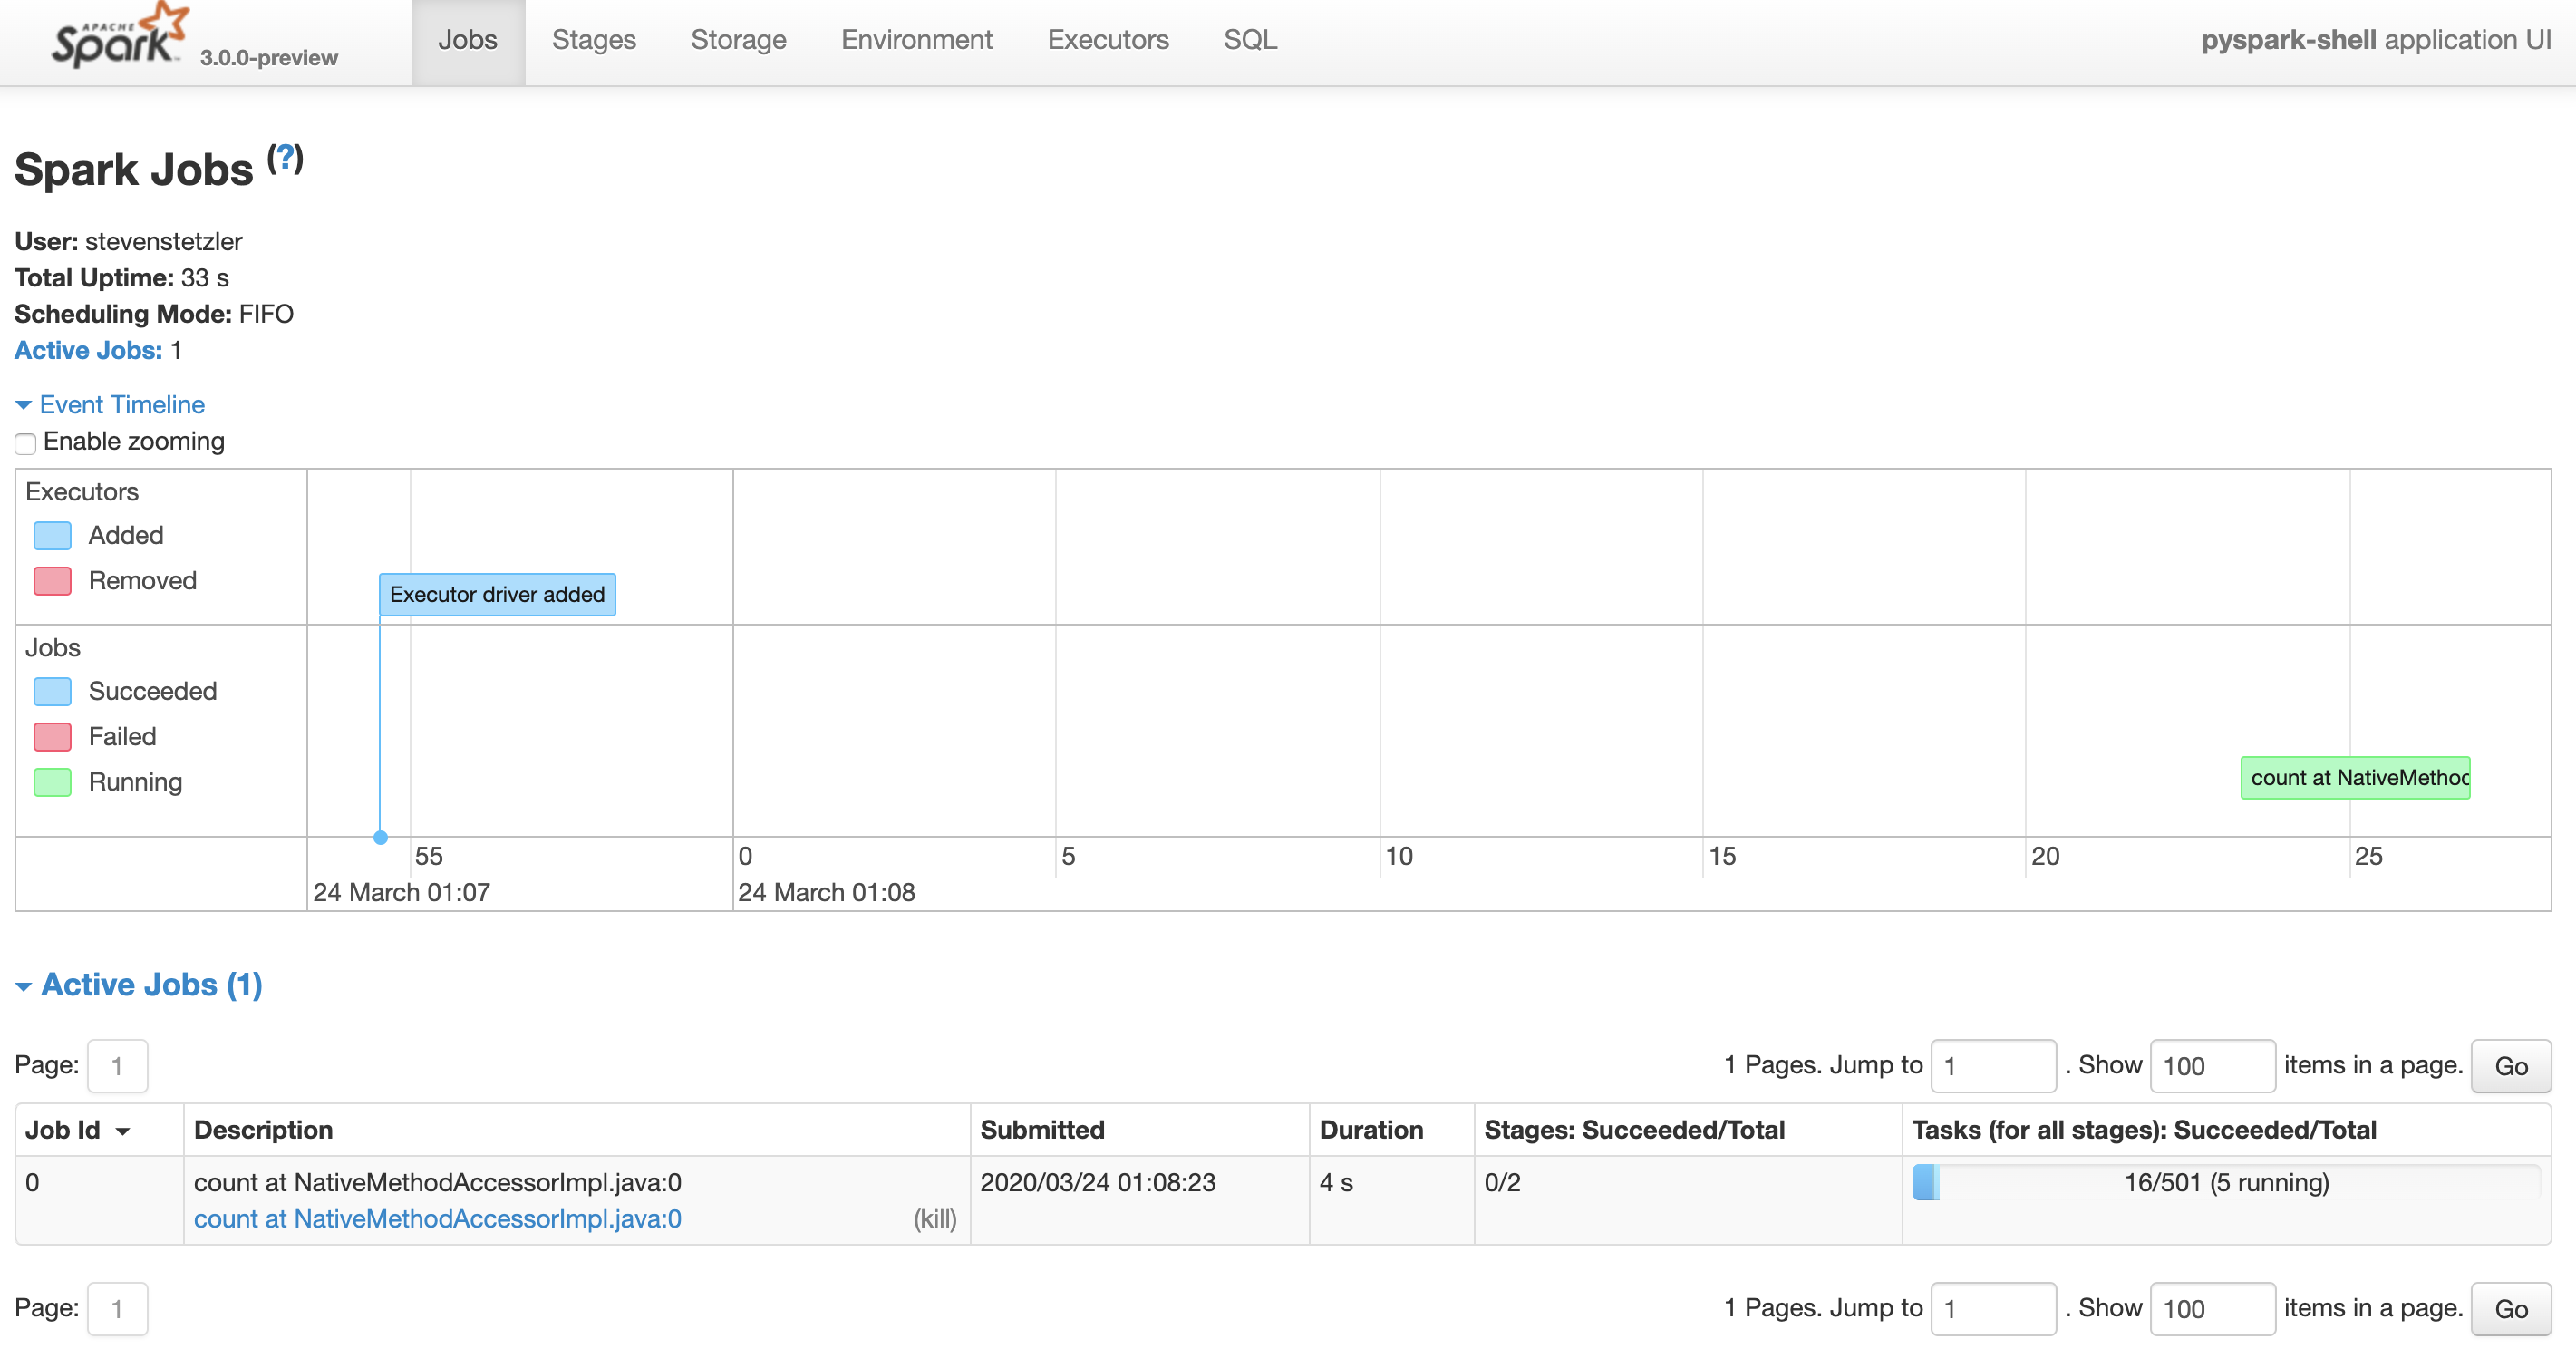
</div>

In [ ]:
port = sc.uiWebUrl.split(":")[-1]
url = f"https://{os.environ['PUBLIC_URL']}/user/{username}/proxy/{port}/jobs/"
print("Dashboard:", url)

### Accessing Catalog Data

We use the Astronomy eXtensions to Spark (AXS, `import axs`) to access our data lake in S3. An `AxsCatalog` stores a descriptor of where added datasets are located (in a metastore database), but it also requires a computation backend, `spark`, in order to perform queries on that data.

In [ ]:
catalog = axs.AxsCatalog(spark)

We can see which datasets we have access to by using `catalog.list_table_names()`. Additionally, we can load an AXS table using `catalog.load()`.

In [ ]:
print(catalog.list_table_names())

In [ ]:
ztf = catalog.load("ztf_light_curves")

The resulting dataset is stored in an `AxsFrame`, which is a subclass of (inherits methods from) Spark's `DataFrame`. We can perform operations on the rows of an `AxsFrame` using Spark's [DataFrame API](https://spark.apache.org/docs/latest/sql-getting-started.html). Example operations are `where()`, which filters out rows based on a set of criteria and `select()`, which selects a subset of columns to include in subsequent computations. Additionally, the AxsFrame API exposes the `region()`, `cone()`, and `crossmatch()` methods. `region()` allows one to subset the data using RA and Dec coordinates in a square region, `cone()` finds rows within a radius distance away of a central location, and `crossmatch()` is an operation that performs a crossmatch between two AxsFrames (e.g. `xmatch = sdss.crossmatch(ztf)`).

The DataFrame API also allows one to map arbitrary user-defined functions (UDFs) written in Python to be mapped onto new columns with the dataset. In the example below, we create a UDF with `dipper.build_analyze_dip_udf` and pass it several rows from the `ztf` AxsFrame, aliasing the results as a new column `dip`. This UDF quantifies how much a given light curve "dips" over time. We can then perform subsequent computation on this new column, such as filtering based on the results of that UDF computation (`dip.significance`).

In [ ]:
dataframe = (
    ztf
    .exclude_duplicates()
    # we've chosen a very small region so that this query will execute in a reasonable amount of time
    .region(ra1=308.80, ra2=314, dec1=19.08, dec2=22.44)
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dipper.build_analyze_dip_udf(max_gap=2.)(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significance") > 10.)
    )
)

We will save the result of the query as a new AxsFrame by calling `catalog.save_axs_table()`. Data will be saved to AWS S3 at the path `{username}/dippers-small` in the "S3 bucket" `ztf-hub-data`. The AXS table will be named `dippers_{username}`, so it will be unique to you. All tables created with `catalog.save_axs_table()` are accessible by anyone using this system! So that means results of computations can easily be shared between users and notebooks without ever moving the data from its location on S3.

In [ ]:
catalog.save_axs_table(dataframe, f"dippers_{username}", path=f"s3a://ztf-hub-data/{username}/dippers-small")

While this runs (it will take a while), let's take a look, by executing the following cell, at the actual UDF being run on each row of the ZTF dataset.

In [ ]:
%load -s analyze_dip dipper.py

You can see that python code of arbitrary complexity and with arbitrary dependencies (we use `numpy` as `np` in the above code) can be run over rows of the dataset with little fuss.

Finally, we'll take a look at the results once the computation has finished. Since we saved the data using `save_axs_table`, we can re-load it with `catalog.load()` and perform more queries on the dataset or collect a few of the results. In the following cell, we load the data, use the DataFrame API to `sort()` the dippers by their `significance` and collect the top five results using the DataFrame `head()` method. Finally we plot the results.

In [ ]:
# Load Dippers catalog
dippers = catalog.load(f"dippers_{username}")

# Sort the dippers by their dip "significance"
dippers_sorted = dippers.sort("dip.significance", ascending=False)

# Give me the top five results
top_five_dippers = dippers_sorted.head(5)

# Plot a light curve
for dip in top_five_dippers:
    dipper.plot_light_curve(dip, verbose=False, label_dip=False)

Below we run the same code except over a set of dippers collected from a larger sky region than shown in the above demo in order for you to see the range of dippers this code will find in the ZTF dataset.

In [ ]:
all_dippers = catalog.load("dippers")

# Sort the dippers by their dip "significance"
dippers_sorted = all_dippers.sort("dip.significance", ascending=False)

# Give me the top five results
top_five_dippers = dippers_sorted.head(5)

# Plot a light curve
for dip in top_five_dippers:
    dipper.plot_light_curve(dip, verbose=False, label_dip=False)

Finally, we'll clean up the AxsFrame we've created and stop the Spark cluster.

In [ ]:
catalog.drop_table(f"dippers_{username}")
spark.stop()